### Challenge 8 : Building a simple GAN and Challenge 11: Generate 50 synthetic images and save them 

In [41]:
import time
start_time=time.time()
import torch
import numpy as np
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [42]:
# Extract 2000 images from the chest X ray dataset and visualize 4 images in a row


# Load the .npz file
data = np.load('all_bucket/marketplace-c3kdc8vj/MedMNIST/120/artifactFiles/chestmnist.npz')

# Extract train images
train_images = data['train_images']
print(f"Shape of the original images: {train_images.shape}")
# Create a directory to store the selected images
output_dir = 'chest_mnist_GAN'
os.makedirs(output_dir, exist_ok=True)

# Number of images to select
num_images_to_select = 2000

# Randomly select 2000 indices
selected_indices = random.sample(range(len(train_images)), num_images_to_select)

# Save the selected images
for i, idx in enumerate(selected_indices):
    # Get the image
    img = train_images[idx]
    
    # Convert the image to PIL Image
    # If the image is 2D, use 'L' mode; if it's 3D, use 'RGB'
    mode = 'L' if len(img.shape) == 2 else 'RGB'
    pil_img = Image.fromarray(img.astype('uint8'), mode)
    
    # Save the image
    img_path = os.path.join(output_dir, f'image_{i:04d}.png')
    pil_img.save(img_path)
    
    # Print progress
    if (i + 1) % 100 == 0:
        print(f"Saved {i + 1} images")

print(f"Saved {num_images_to_select} images to {output_dir}")

Shape of the original images: (78468, 28, 28)
Saved 100 images
Saved 200 images
Saved 300 images
Saved 400 images
Saved 500 images
Saved 600 images
Saved 700 images
Saved 800 images
Saved 900 images
Saved 1000 images
Saved 1100 images
Saved 1200 images
Saved 1300 images
Saved 1400 images
Saved 1500 images
Saved 1600 images
Saved 1700 images
Saved 1800 images
Saved 1900 images
Saved 2000 images
Saved 2000 images to chest_mnist_GAN


Loaded image_1638.png with shape: (28, 28)
Loaded image_0338.png with shape: (28, 28)
Loaded image_1665.png with shape: (28, 28)
Loaded image_0392.png with shape: (28, 28)
Loaded image_0672.png with shape: (28, 28)
Loaded image_0707.png with shape: (28, 28)
Loaded image_1317.png with shape: (28, 28)
Loaded image_1766.png with shape: (28, 28)
Loaded image_0166.png with shape: (28, 28)
Loaded image_1994.png with shape: (28, 28)
Loaded image_0034.png with shape: (28, 28)
Loaded image_1599.png with shape: (28, 28)
Loaded image_1410.png with shape: (28, 28)
Loaded image_0466.png with shape: (28, 28)
Loaded image_1625.png with shape: (28, 28)
Loaded image_0528.png with shape: (28, 28)


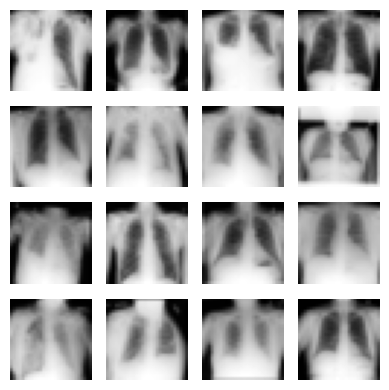

In [43]:

# Directory containing the images
input_dir = 'chest_mnist_GAN'

# List all image files in the directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Load the images and check their shape
images = []
for img_file in image_files[:16]:  # Load only the first 16 images
    img_path = os.path.join(input_dir, img_file)
    img = Image.open(img_path)
    images.append(img)
    print(f"Loaded {img_file} with shape: {img.size}")

# Display 16 images in a 4x4 grid
plt.figure(figsize=(4, 4))
for i, img in enumerate(images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [44]:
# data loaders
class ChestMNISTDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # norm [-1,1], as we used tanh activation in generator output
])

# create  dataloaders
dataset = ChestMNISTDataset(image_dir='chest_mnist_GAN', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [45]:
#generator architecture, we use DCGAN, use transpose conv layers to upsample a latent vector to generate images of shape [28,28]
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [46]:
# Define a discriminator architecture, it classifies whether the sample comes from generated output or the real dataset
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [47]:
# Hyperparameters
noise_dim = 100
img_channels = 1
batch_size = 64
lr = 0.0002

# Initialize models
generator = Generator(noise_dim, img_channels)
discriminator = Discriminator(img_channels)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [48]:
# Hyperparameters
noise_dim = 100
img_channels = 1
lr = 0.0002

# Initialize models
generator = Generator(noise_dim, img_channels)
discriminator = Discriminator(img_channels)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    for real_images in dataloader:
        batch_size = real_images.size(0)
        
        # Flatten real images for the discriminator
        real_images = real_images.view(batch_size, img_channels, 28, 28)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Compute loss on real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(batch_size, noise_dim, 1, 1)
        fake_images = generator(z)

        # Compute loss on fake images
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim, 1, 1)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        
        # Compute loss
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
          f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

Epoch [1/15], d_loss: 0.0902, g_loss: 3.1538, D(x): 0.97, D(G(z)): 0.06
Epoch [2/15], d_loss: 0.1534, g_loss: 3.6700, D(x): 0.93, D(G(z)): 0.05
Epoch [3/15], d_loss: 0.0469, g_loss: 4.2317, D(x): 0.99, D(G(z)): 0.03
Epoch [4/15], d_loss: 0.1887, g_loss: 2.7691, D(x): 0.93, D(G(z)): 0.10
Epoch [5/15], d_loss: 1.3378, g_loss: 3.0632, D(x): 0.94, D(G(z)): 0.70
Epoch [6/15], d_loss: 1.1055, g_loss: 2.9454, D(x): 0.88, D(G(z)): 0.60
Epoch [7/15], d_loss: 0.9570, g_loss: 0.9261, D(x): 0.59, D(G(z)): 0.31
Epoch [8/15], d_loss: 1.0292, g_loss: 0.8730, D(x): 0.56, D(G(z)): 0.35
Epoch [9/15], d_loss: 0.9693, g_loss: 0.9545, D(x): 0.53, D(G(z)): 0.25
Epoch [10/15], d_loss: 1.0795, g_loss: 1.0237, D(x): 0.50, D(G(z)): 0.29
Epoch [11/15], d_loss: 1.0704, g_loss: 1.1908, D(x): 0.59, D(G(z)): 0.41
Epoch [12/15], d_loss: 1.2069, g_loss: 1.5202, D(x): 0.68, D(G(z)): 0.53
Epoch [13/15], d_loss: 0.9187, g_loss: 1.7884, D(x): 0.66, D(G(z)): 0.38
Epoch [14/15], d_loss: 1.1236, g_loss: 1.9856, D(x): 0.77, D

In [49]:
end_time=time.time()
total_time=end_time-start_time
print(total_time)

105.58908224105835


### Time taken for the task 8 is 105.6 sec

### Ch :11 , Generate 50 synthetic images

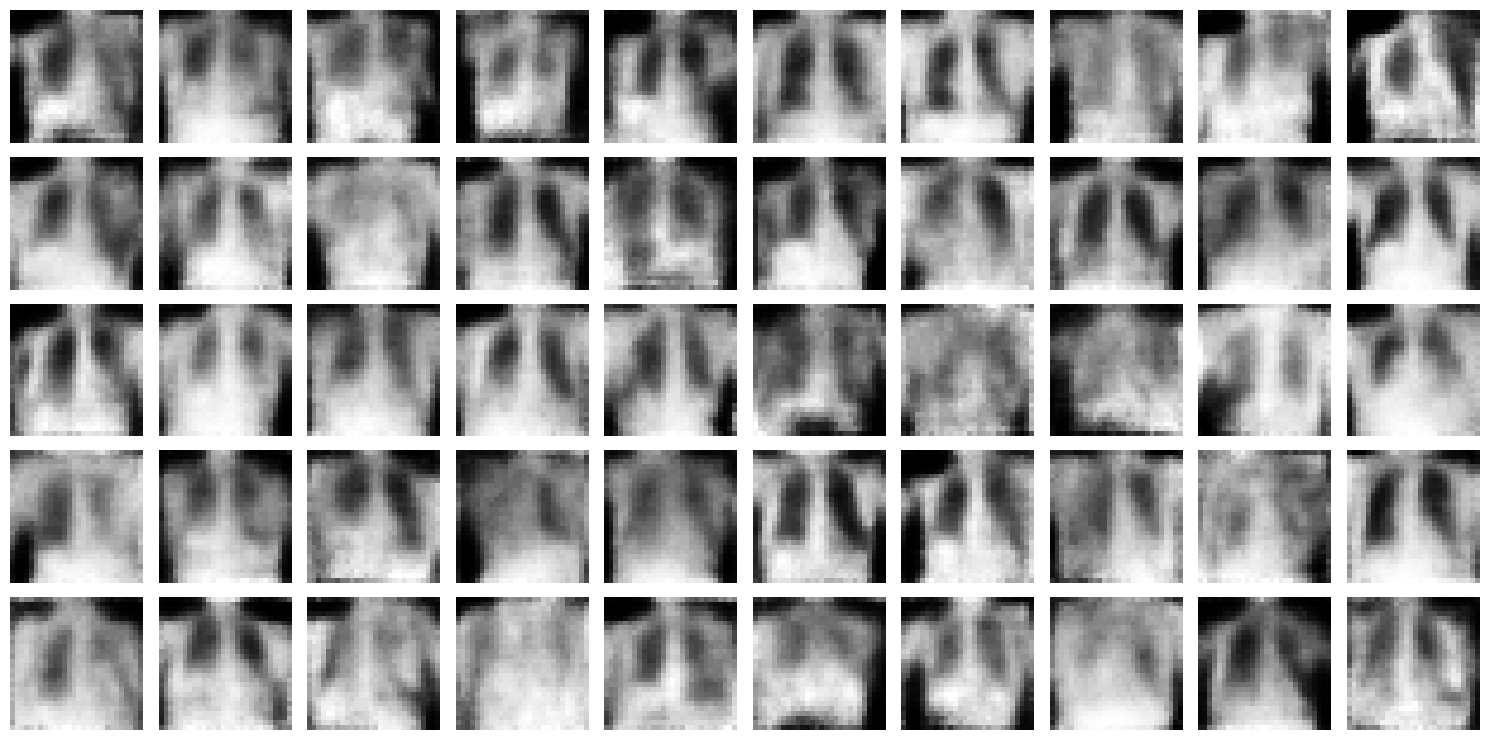

In [50]:

start_infer=time.time()
# Set the generator to evaluation mode
generator.eval()

# Number of samples to generate
num_samples = 50

# Generate random noise
z = torch.randn(num_samples, noise_dim, 1, 1)

# Generate images from the noise
with torch.no_grad():
    generated_images = generator(z)

# reshape
generated_images = generated_images.view(num_samples, 1, 28, 28)
generated_images = (generated_images + 1) / 2  # Rescale to [0, 1] for display

## Display the generated images
plt.figure(figsize=(15, 7.5))
for i in range(num_samples):
    plt.subplot(5, 10, i + 1)
    plt.imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [51]:
end_infer=time.time()
total_time=end_infer-start_infer
print(total_time)

4.266094207763672


### Time taken for task 11 is 4.266 seconds